# Initial reaction rate prediction in mixtures
## Getting started
### In this code the goal is to obtain initial reaction rate parameters corresponding to the basic Mendel formula using components activities, rather than components concentrations.
### The basic formula is the following:
$$
V_i=\frac{V_ma_{component_1}a_{component_2}}{Km_{component_1}a_{component_2}(a+\frac{a_{component_2}}{K_i})+Km_{component_1}a_{component_2}+a_{component_1}a_{componen_2}}
$$


### Libraries to import

In [1]:
#first we import all the necessary libraries
import kinetics      #this library has no use for now, but it might be used in future updates
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import least_squares
from thermo.unifac import UNIFAC, UFSG, UFIP
from thermo.chemical import Chemical
from ugropy import Groups
#feel free to import any other library you might need

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19


## Data insertion
### The first crutial step is to input the experimental conditions that you want to evaluate
### It is important to note the following things:
1. Temperatures in thermo and chemical are read in Kelvin
2. Pressures in thermo and chemical are read in Pascals
3. Make sure that the names are consistent with the way the are written in the thermo dictionaries
4. This code can work with a pure solvent or with solvent mixtures, however, you must be consistent with the order of the components 
5. Experimental data can be in 'mol/L' or 'g/L'

In [ ]:
#First we define the conditions fow which we will obtain the corresponding activity coefficients and initial reaction rate
T=20+273.15    #Temperature in Kelvin
P=100000       #Pressure in Pascals
substrates_and_h2o_present=['oleic acid','ethanol','water']   #List of components present in the solution(excluding solvents)
concentration_datas=[[[0.2,0.2,0.2,0.2,0.2,0.2,0.2],'mol/L'],[[0.05,0.1,0.2,0.3,0.5,0.75,1],'mol/L'],[[0.4,0.4,0.43,0.47,0.57,0.73,0.83],'g/L']]       #List of concentration of each component present and the units they are in (they must be in mol/L or g/L)
#the order in which you submit the components name must be the same as the order in which you submit the concentrations
#the following list is in case the solvent is composed of one component
solvent_used=['hexane','heptane','cyclohexane','isooctane']               #list of solvents used in the solution
#the following list is in case the solvent is composed of two components or more
#most of the same logic applies
conc_data_fm2h=[[[0.2,0.2,0.2,0.2,0.2,0.2,0.2],'mol/L'],[[0.05,0.1,0.2,0.3,0.5,0.75,1],'mol/L'],[[7,7,7.5,8,8.5,9.5,10.5],'g/L']]
conc_data_fm2h_75_percent=[[[0.2,0.2,0.2,0.2,0.2,0.2,0.2],'mol/L'],[[0.05,0.1,0.2,0.3,0.5,0.75,1],'mol/L'],[[5.4,5.5,5.9,6,6.8,7.5,8.5],'g/L']]
conc_data_fm2h_50_percent=[[[0.2,0.2,0.2,0.2,0.2,0.2,0.2],'mol/L'],[[0.05,0.1,0.2,0.3,0.5,0.75,1],'mol/L'],[[3.9,4,4.2,4.4,5,5.5,6.4],'g/L']]
conc_data_fm2h_25_percent=[[[0.2,0.2,0.2,0.2,0.2,0.2,0.2],'mol/L'],[[0.05,0.1,0.2,0.3,0.5,0.75,1],'mol/L'],[[2.2,2.4,2.6,2.7,3.1,3.6,4.3],'g/L']]
conc_data_fm2h_10_percent=[[[0.2,0.2,0.2,0.2,0.2,0.2,0.2],'mol/L'],[[0.05,0.1,0.2,0.3,0.5,0.75,1],'mol/L'],[[0.5,0.5,0.6,0.7,0.8,0.9,1.1],'g/L']]
solvent_mixtures=[[['hexane','5-methyl-2-hexanone'],[0,1]],[['hexane','5-methyl-2-hexanone'],[0.25,0.75]],[['hexane','5-methyl-2-hexanone'],[0.5,0.5]],[['hexane','5-methyl-2-hexanone'],[0.75,0.25]],[['hexane','5-methyl-2-hexanone'],[0.9,0.1]]]     #list of solvent mixtures, where each component of the list is a list of the components present in the mixture and the other list contains the volume fraction of each component in the mixture, in order





## Properties 
### This function is useful if you need a component's density and molar mass under the conditions you are working with, all you need to insert is the component's name(in english), the pressure and temperature of the system you are working with

In [ ]:
#this simple function allows us to obtain the molar mass and density of a component given its name and operation conditions
#It uses the Chemical class from the thermo library
def get_component_properties(component,T,P):
    # the fed inputs are the component name, temperature in Kelvin and pressure in pascals
    component_name=Chemical(component,T=T,P=P)
    density=component_name.rho
    molar_mass=component_name.MW
    #It returns a list containing the molar mass and density of the component
    return [density,molar_mass]

## Molar fractions determination
### This function's goal is to determine the components molar fraction based on the experimental data you are using, this method works as long as the ammount of solvent is significantly higher than the other components
#### Tip: if you already have the moles/grams you are using you can skip this function

In [ ]:
#this function will return a list with the molar fraction of each component present in the solution for as many experiments as you want
def get_components_molar_fractions(substrates_used,concentration_data,solvent_used,T,P,is_mixture):
    #this function will return a list of molar fractions of the components present in the solution for every variation you submit
    #first, it will determine the molar mass and density of each component and solvent using Chemical from thermo
    molar_fractions=[]
    #first we get the properties of the solvent
    if is_mixture==False:
        solvent_density,solvent_molar_mass=get_component_properties(solvent_used,T,P)
        #now we will obtain the moles of the solvent
        solvent_moles=solvent_density*1/solvent_molar_mass   #assuming 1 L of solvent, we get the values in kg/m3 but to convert it to g/L we don't need to multiply by 1000
    elif is_mixture==True:
        #if the solvent is a mixture, we must calculate the moles of each component present
        number_of_components_in_mixture=len(solvent_used[0])
        solvent_moles=[]
        for i in range(number_of_components_in_mixture):
            comp_name=solvent_used[0][i]
            comp_volume_fraction=solvent_used[1][i]
            comp_density,comp_molar_mass=get_component_properties(comp_name,T,P)
            comp_moles=1*comp_volume_fraction*comp_density/comp_molar_mass  #assuming 1 L of solution
            solvent_moles.append(comp_moles)
    components_present=len(substrates_used)
    experiments_to_evaluate=len(concentration_data[0][0])    #this is the number of experiments we want to evaluate
    for i in range(experiments_to_evaluate):
        #first we want to obtain the data from the first experiment to evaluate
        experiment_concentrations=[]
        experiment_units=[]
        for j in range(components_present):
            comp_conc=concentration_data[j][0][i]   #this is the concentration of the component
            comp_unit=concentration_data[j][1]
            experiment_concentrations.append(comp_conc)
            experiment_units.append(comp_unit)
        #with this we have the concentration and units of every component present in the experiment
        #now we need to calculate the moles of each component(assuming 1 L of solution and using the molar mass and density of each component)
        components_moles=[]
        for k in range(components_present):
            comp_name=substrates_used[k]
            comp_conc=experiment_concentrations[k]
            comp_unit=experiment_units[k]
            density_k,MW_k=get_component_properties(comp_name,T,P)
            if comp_unit=='g/L':
                moles_k=(comp_conc*1)/MW_k    #assuming the 1L of solution
            elif comp_unit=='mol/L':
                moles_k=comp_conc*1
            else:
                raise ValueError('Units must be g/L or mol/L')
            components_moles.append(moles_k)
        #now we can finally calculate their molar fractions
        if is_mixture==False:
           total_moles=solvent_moles+sum(components_moles)
           k_mole_fractions=[]
           for s in range(len(components_moles)):
              mole_frac=components_moles[s]/total_moles
              k_mole_fractions.append(mole_frac)
             #we append the solvent molar fraction
           k_mole_fractions.append(solvent_moles/total_moles)
           molar_fractions.append([i+1,k_mole_fractions])   #we append the experiment number and the corresponding molar fractions of each component
        elif is_mixture==True:
            total_moles=sum(solvent_moles)+sum(components_moles)
            k_mole_fractions=[]
            for s in range(len(components_moles)):
               mole_frac=components_moles[s]/total_moles
               k_mole_fractions.append(mole_frac)
            #we append the solvent molar fraction
            for s in range(len(solvent_moles)):
                mole_frac=solvent_moles[s]/total_moles
                k_mole_fractions.append(mole_frac)
            molar_fractions.append([i+1,k_mole_fractions])

    return molar_fractions

## Activity coefficients 
### The kinetic reaction formula requires the activity of each substrate, where the activity is given by the following formula:
$$
a_i=x_i \gamma_i
$$
### Where $x_i$ is the molar fraction of the component i and $\gamma_i$ is it's activity coefficient
### This function utilizes the thermo library to determine the activity coefficients of all components(please note that you may not need all of the activity coefficients) using the UNIFAC databank, in order for this function to work UNIFAC needs the molar fractions and chemical subgroups of each component, along with the temperature of operation
### This function also utilizes the ugropy library to obtain the chemical subgroups based on the original UNIFAC database
#### Tip:In case that you are using a component that isn't recognized by the UNIFAC database, feel free to manually add it in the code
### To learn more about the libraries used feel free to read their documentation for:
### [thermo](https://thermo.readthedocs.io/index.html#)
### [ugropy](https://github.com/ipqa-research/ugropy)

In [ ]:
#this is the most crucial function of the code, it uses the ugropy library to obtain the chemical subgroups present in each component and then uses the UNIFAC model of ones choosing to calculate the activity coefficients of each component in each experiment
def get_activity_coefficients(substrates_used,solvent_used,experiments_molar_fractions,T,P,is_mixture):
    #This function will return a list of activity coefficients for each component in each experiment
    activity_coefficients=[]
    #first we must define the chemical subgroups of every component
    chemical_subgroups=[]
    if is_mixture==False:
       number_of_comp=len(substrates_used)+ 1  #+1 for the solvent used
       list_of_all_components=substrates_used+[solvent_used]  #this creates a list with all components present in the solution
    elif is_mixture==True:
        number_of_comp=len(substrates_used)+len(solvent_used[0])
        list_of_all_components=substrates_used+solvent_used[0]  #this creates a list with all components present in the solution
    for i in range(number_of_comp):
        component_name=list_of_all_components[i]
        component_subgroups_names = Groups(component_name)
        sub = component_subgroups_names.unifac.subgroups
        # Build subgroup name-to-index dict using .group attribute
        name2idx = {UFSG[k].group: k for k in UFSG}
        # Map ugropy output to indexes
        index = {name2idx[name]: count for name, count in sub.items()}
        chemical_subgroups.append(index)
    #now that we have the chemical subgroups of each component and the molar fractions of each component in each experiment, we can get the activity coefficients for each one
    number_of_experiments=len(experiments_molar_fractions)
    for j in range(number_of_experiments):
        model=UNIFAC.from_subgroups(T=T,xs=experiments_molar_fractions[j][1],chemgroups=chemical_subgroups,subgroups=UFSG,interaction_data=UFIP,version=0)
        activity_coeffs=model.gammas()
        #we append the activity coefficients of each component of the experiment in the list
        activity_coefficients.append([j+1,activity_coeffs])  #we append the experiment number and the corresponding activity coefficients of each component
    return activity_coefficients

## Initial reaction rate
### This function determines the initial reaction rate with the substrates molar fraction and activity coefficients
### Remembering that the base reaction formula being used is
$$
V_i=\frac{V_ma_{component_1}a_{component_2}}{Km_{component_1}a_{component_2}(a+\frac{a_{component_2}}{K_i})+Km_{component_1}a_{component_2}+a_{component_1}a_{componen_2}}
$$
### Where $V_m$ corresponds to the maximum initial reaction rate, Km correspond to the rate constants of the different components and Ki corresponds to the inhibition constant
### Feel free to modify the initial reaction rate equation if needed


In [ ]:
#This function determines the intial reaction rate of each experiment
def initial_reaction_rate(substrates_used,concentration_data,experimental_mole_fractions,experimental_activity_coeffs,params):
    #this function will return a list of initial reaction rates for the different experiments and plot the results
    #Comment to teach:This part would require to use a python solver to find the correct kinetic parameters from the reaction rate equation, will have preedetermined values as stand-ins for now
    initial_rx_rates=[]
    #first we define the kinetic equation
    #after going insane thinking about the system, i concluded that it is best to not use the kinetics library, instead we will directly calculate the initial reaction rate using the parameters and the activities of the components
    #initial_rx_rate=kinetics.Generic(params=['Vm','km1','km2','Ki'],species=['activity_1','activity_2'],rate_equation='(Vm*activity_1*activity_2)/(km1*activity_2*(1+activity_2/Ki)+km2*activity_1+activity_1*activity_2)')
    #we will use the activity coefficients and molar fractions to obtain the activities of the two components of interest
    number_of_experiments=len(experimental_mole_fractions)
    for i in range(number_of_experiments):
        #initial_rx_rate.parameters={'Vm':params[0],'km1':params[1],'km2':params[2],'Ki':params[3]}   #This parameters are to be perfected with a solver
        #we will use the first two components as the ones of interest
        actv_first_component=experimental_mole_fractions[i][1][0]*experimental_activity_coeffs[i][1][0]  #activity of the first component in the i experiment
        actv_second_component=experimental_mole_fractions[i][1][1]*experimental_activity_coeffs[i][1][1]  #activity of the second component in the i experiment
        #now that we set the activities of the experiment, we can calculate the corresponding initial reaction rate
        #Vi_i=kinetics.Model()
        #Vi_i.append(initial_rx_rate)
        #Vi_i.set_species={'activity_1':actv_first_component,'activity_2':actv_second_component}
        #Now with the model set we can try and run the model to see what initial reaction rate we get
        #Vi_i.setup_model()
        #initial_rate_rx_i=Vi_i.run_model()
        Vm=params[0]  #maximum initial reaction rate
        km1=params[1] #rate constant for the first component
        km2=params[2] #rate constant for the second component
        Ki=params[3] #inhibition constant
        initial_rate_rx_i=(Vm*actv_first_component*actv_second_component)/(km1*actv_second_component*(1+actv_second_component/Ki)+km2*actv_first_component+actv_first_component*actv_second_component)
        #we append the initial reaction rate of the i experiment
        initial_rx_rates.append([i+1,initial_rate_rx_i])
    return initial_rx_rates

## System optimization
### The initial reaction rate equation usually contains constants that remain the same regardless of the components and solvent used. In order to obtain constants that best adjust to the systems that you desire to predict, this code will use a standard least squares method from the SciPy library, to learn other more complex methods of optimization feel free to view the library documentation
### This system's goal is to compare the initial reaction rates obtained experimentally with the ones predicted with the code, minimizing the square error between this two cases
### [SciPy](https://docs.scipy.org/doc/scipy/)

In [ ]:
#This objective function will be used to optimize the model parameters
def objective_function(params,experimental_data,substrates_used,concentration_data,experimental_mole_fractions,experimental_activity_coeffs):
    #this function will return the sum of squared differences between the experimental initial reaction rates and the calculated ones
    calculated_initial_rx_rates=initial_reaction_rate(substrates_used,concentration_data,experimental_mole_fractions,experimental_activity_coeffs,params)
    #now we will extract the initial rx rates from the calculated list
    calculated_data=[]
    for i in range(len(calculated_initial_rx_rates)):
        calculated_data.append(calculated_initial_rx_rates[i][1])
    #now that we have the calculated data, we can calculate the sum of squared differences
    residuals = [calc - exp for calc, exp in zip(calculated_data, experimental_data)]    #with this we put the elements in calculated_data and experimental_data into pairs and calculate the difference between them
    return np.array(residuals)  # least_squares will minimize the sum of squares of these
#now that we defined our objective function, we can use least_squares to optimize the model parameters

In [ ]:
#This function is in charge of optimizing the model parameters
def optimize_model_parameters(experimental_rates,substrates_used,concentration_data,experimental_mole_fractions,experimental_activity_coeffs,initial_params):
    #this function will return the optimized model parameters
    bounds=([0, 0, 0, 0], [np.inf, 1, 1, 1])   #bounds for the parameters
    result=least_squares(objective_function,initial_params, args=(experimental_rates, substrates_used,concentration_data, experimental_mole_fractions, experimental_activity_coeffs), bounds=bounds)
    return result.x  #optimized parameters

## Optimization example

In [ ]:
#now we will define the experimentally obtained initial reaction rates for the first solvent and optimize the model parameters that best fit the data
experimental_initial_rx_rates=[0.002688075733451346, 0.0033269997642950258, 0.0026868635364406496, 0.0022925724071250246, 0.0019220826699120193, 0.0015921341882489818, 0.001172136785850005]
#we will use the first solvent to calibrate the model parameters
solvent_to_evaluate=solvent_used[0]   #hexane
substrates_molar_fractions=get_components_molar_fractions(substrates_and_h2o_present,concentration_datas,solvent_to_evaluate,T,P,False)
#this will give us the molar fraction of each component in each experiment with hexane as our solvent
oacid_and_ethanol_coeffs=get_activity_coefficients(substrates_and_h2o_present,solvent_to_evaluate,substrates_molar_fractions,T,P,False)
initial_params=[20,0.1,0.1,0.1]   #initial guess for the parameters
#this will give us the activity coefficients of each component in each experiment (note that for this final part we only care about oacid and ethanol coefficients)
#now we need to calculate the initial reaction rates, giving us the values that we will need to optimize
optimized_params=optimize_model_parameters(experimental_initial_rx_rates, substrates_and_h2o_present, concentration_datas, substrates_molar_fractions, oacid_and_ethanol_coeffs,initial_params)
print("The list hands in the model parameters in the following order:Vm,km1,km2,Ki ",optimized_params)

The list hands in the model parameters in the following order:Vm,km1,km2,Ki  [0.05647288 0.20691655 0.9978905  0.62483933]


## Activity coefficients visualization
### This function is designed to present the activity coefficients in a clean and easy to read matter

In [ ]:
def print_coeff_table(solvent_name, experimental_activity_coeffs, concentration_data):
    eth_col_width = 15
    oa_col_width = 15
    eth_gamma_col_width = 15


    print(f"\n Solvent: {solvent_name}")
    print(f"| {'[Eth]  M':^{eth_col_width}} | {'γ OA':^{oa_col_width}} | {'γ Eth':^{eth_gamma_col_width}} |")
    print("|-----------------|-----------------|-----------------|")

    number_of_experiments = len(experimental_activity_coeffs)
    for i in range(number_of_experiments):
        eth_concentration = concentration_data[1][0][i]
        oa_gamma, eth_gamma = experimental_activity_coeffs[i][1][0], experimental_activity_coeffs[i][1][1]
        # All numbers are right-aligned, use the same width as the columns
        print(f"| {eth_concentration:>{eth_col_width}.2f} | {oa_gamma:>{oa_col_width}.3f} | {eth_gamma:>{eth_gamma_col_width}.3f} |")

    print("|-----------------|-----------------|-----------------|")
print_coeff_table(solvent_to_evaluate,oacid_and_ethanol_coeffs,concentration_datas)




 Solvent: hexane
|    [Eth]  M     |      γ OA       |      γ Eth      |
|-----------------|-----------------|-----------------|
|            0.05 |           0.981 |          16.386 |
|            0.10 |           0.911 |          15.162 |
|            0.20 |           0.796 |          13.107 |
|            0.30 |           0.709 |          11.497 |
|            0.50 |           0.588 |           9.172 |
|            0.75 |           0.494 |           7.282 |
|            1.00 |           0.438 |           6.060 |
|-----------------|-----------------|-----------------|


## Example

In [ ]:
for i in range(len(solvent_used)):
    solvent_to_evaluate=solvent_used[i]
    susbtrates_molar_fractions_for_specific_solvent=get_components_molar_fractions(substrates_and_h2o_present, concentration_datas, solvent_to_evaluate, T, P,False)
    activity_coefficients_for_specific_solvent=get_activity_coefficients(substrates_and_h2o_present, solvent_to_evaluate, susbtrates_molar_fractions_for_specific_solvent, T, P,False)
    print_coeff_table(solvent_to_evaluate,activity_coefficients_for_specific_solvent,concentration_datas)
    


 Solvent: hexane
|    [Eth]  M     |      γ OA       |      γ Eth      |
|-----------------|-----------------|-----------------|
|            0.05 |           0.981 |          16.386 |
|            0.10 |           0.911 |          15.162 |
|            0.20 |           0.796 |          13.107 |
|            0.30 |           0.709 |          11.497 |
|            0.50 |           0.588 |           9.172 |
|            0.75 |           0.494 |           7.282 |
|            1.00 |           0.438 |           6.060 |
|-----------------|-----------------|-----------------|

 Solvent: heptane
|    [Eth]  M     |      γ OA       |      γ Eth      |
|-----------------|-----------------|-----------------|
|            0.05 |           1.193 |          15.709 |
|            0.10 |           1.109 |          14.555 |
|            0.20 |           0.969 |          12.610 |
|            0.30 |           0.863 |          11.082 |
|            0.50 |           0.714 |           8.870 |
|          

## Sensibility analisis
### This line of code's goal is to compare the optimized results given different initial parameters prediction, feel free to add/remove more predictions

In [ ]:
#now we will evaluate the sensitivity of the model parameters, doing a variety of initial guesses and seeing how the optimized model parameters change
experimental_initial_rx_rates=[0.002688075733451346, 0.0033269997642950258, 0.0026868635364406496, 0.0022925724071250246, 0.0019220826699120193, 0.0015921341882489818, 0.001172136785850005]
#we will use the first solvent to calibrate the model parameters
solvent_to_evaluate=solvent_used[0]   #hexane
substrates_molar_fractions=get_components_molar_fractions(substrates_and_h2o_present,concentration_datas,solvent_to_evaluate,T,P,False)
#this will give us the molar fraction of each component in each experiment with hexane as our solvent
oacid_and_ethanol_coeffs=get_activity_coefficients(substrates_and_h2o_present,solvent_to_evaluate,substrates_molar_fractions,T,P,False)
initial_Vm=np.linspace(0.05,10,10)
initial_km1=np.linspace(0.01,1,10)
initial_km2=np.linspace(0.01,1,10)
initial_Ki=np.linspace(0.01,1,10)
#with this initial params sets we will evaluate the sensitivity of the model parameters
#we will print every optimized parameter for each initial guess to evaluate the sensitivity
for i in range(len(initial_Vm)):
    initial_params=[initial_Vm[i],initial_km1[1],initial_km2[i],initial_Ki[i]]
    optimized_params=optimize_model_parameters(experimental_initial_rx_rates,substrates_and_h2o_present,concentration_datas,substrates_molar_fractions,oacid_and_ethanol_coeffs,initial_params)
    print(f"Initial params: {initial_params}, Optimized params: {optimized_params}")

Initial params: [np.float64(0.05), np.float64(0.12), np.float64(0.01), np.float64(0.01)], Optimized params: [0.03823502 0.12871272 0.68551377 0.54294142]
Initial params: [np.float64(1.1555555555555554), np.float64(0.12), np.float64(0.12), np.float64(0.12)], Optimized params: [0.057012   0.21049017 0.99622079 0.63145176]
Initial params: [np.float64(2.2611111111111106), np.float64(0.12), np.float64(0.23), np.float64(0.23)], Optimized params: [0.05605286 0.20320065 0.99814972 0.61057926]
Initial params: [np.float64(3.3666666666666663), np.float64(0.12), np.float64(0.34), np.float64(0.34)], Optimized params: [0.05600993 0.20253657 0.99945218 0.60747074]
Initial params: [np.float64(4.472222222222221), np.float64(0.12), np.float64(0.45), np.float64(0.45)], Optimized params: [0.05666691 0.20807112 0.99991724 0.62759368]
Initial params: [np.float64(5.577777777777777), np.float64(0.12), np.float64(0.56), np.float64(0.56)], Optimized params: [0.05373243 0.19212589 0.96299492 0.5948487 ]
Initial 

## Solvents comparison
### This line of code is designed to plot the initial reaction rate of different solvents, where the X axis is the initial concentration of a substrate and the y axis corresponds to the initial reaction rates in said initial concentrations
### This line of code also allows the user to plot the activity coefficients of different components in different experimental initial conditions

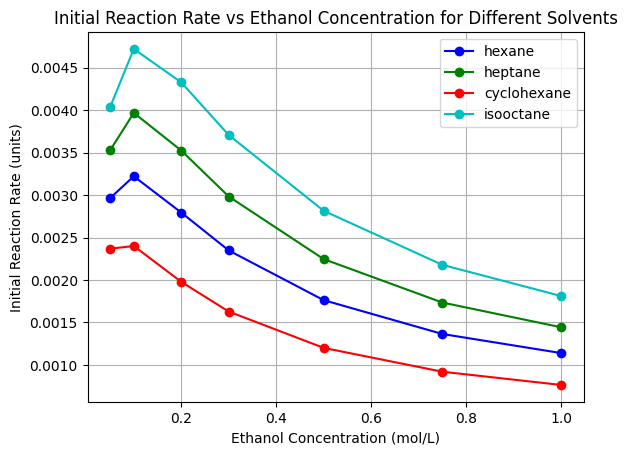

In [ ]:
optimized_params=[0.05846361, 0.20808054,0.892742  , 0.51688645]
#now that we have the optimized parameters, we can start plotting the results for the different solvents
#now we will calculate the initial reaction rates for all solvents using this optimized parameters
solvents_initial_rx_rates=[]    #this list will store the initial reaction rates for each solvent
solvents_activity_coeffs=[]   #this list will store the activity coeffs of oleic acid and ethanol for each solvent
for i in range(len(solvent_used)):
    solvent_to_evaluate=solvent_used[i]
    susbtrates_molar_fractions_for_specific_solvent=get_components_molar_fractions(substrates_and_h2o_present, concentration_datas, solvent_to_evaluate, T, P,False)
    activity_coefficients_for_specific_solvent=get_activity_coefficients(substrates_and_h2o_present, solvent_to_evaluate, susbtrates_molar_fractions_for_specific_solvent, T, P,False)
    initial_rx_rates_for_specific_solvent=initial_reaction_rate(substrates_and_h2o_present, concentration_datas, susbtrates_molar_fractions_for_specific_solvent, activity_coefficients_for_specific_solvent, optimized_params)
    #with this we have the initial reaction rates for the specific solvent
    rx_rates_for_solvent=[]
    activity_coeffs_for_solvent=[]
    for j in range(len(initial_rx_rates_for_specific_solvent)):
        rx_rates_for_solvent.append(initial_rx_rates_for_specific_solvent[j][1])  #we append the initial reaction rates for the specific solvent
        activity_coeffs_for_solvent.append([activity_coefficients_for_specific_solvent[j][1][0],activity_coefficients_for_specific_solvent[j][1][1]])  #we append the activity coefficients for the specific solvent
    solvents_initial_rx_rates.append(rx_rates_for_solvent)
    solvents_activity_coeffs.append(activity_coeffs_for_solvent)
#now we have the initial reaction rates for each solvent under the same experimental conditions
#we can now plot all results in a single graph

plt.figure()
colors = ['b', 'g', 'r', 'c']  # Choose as many colors as solvents
ethanol_conc = concentration_datas[1][0]  # X axis
#The following loop will plot the initial reaction rates for each solvent
for i, solvent in enumerate(solvent_used):
    rates = solvents_initial_rx_rates[i]
    plt.plot(ethanol_conc, rates, marker='o', color=colors[i % len(colors)], label=solvent)
#The following lines of code will set the labels and title of the plot
plt.xlabel("Ethanol Concentration (mol/L)")
plt.ylabel("Initial Reaction Rate (units)")
plt.title("Initial Reaction Rate vs Ethanol Concentration for Different Solvents")
plt.legend()
plt.grid(True)
plt.show()

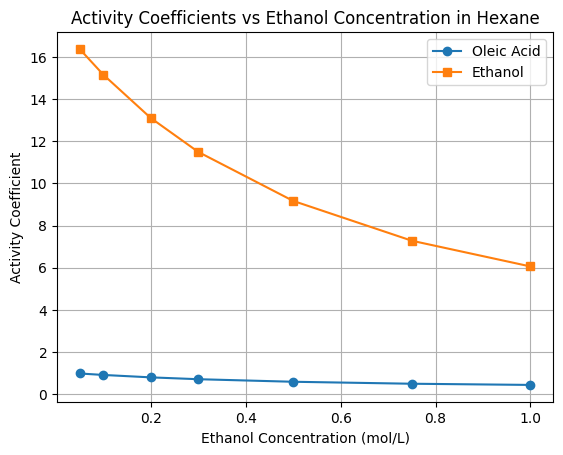

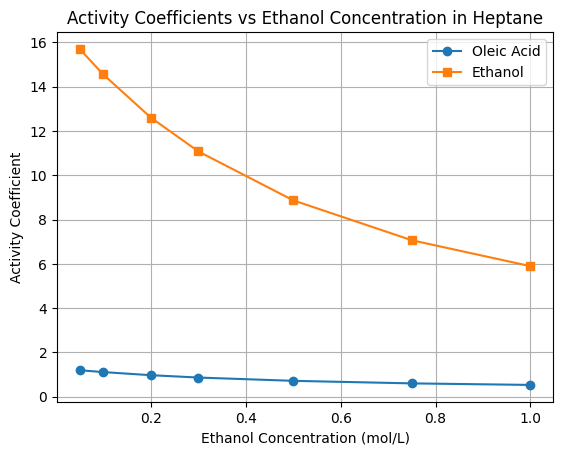

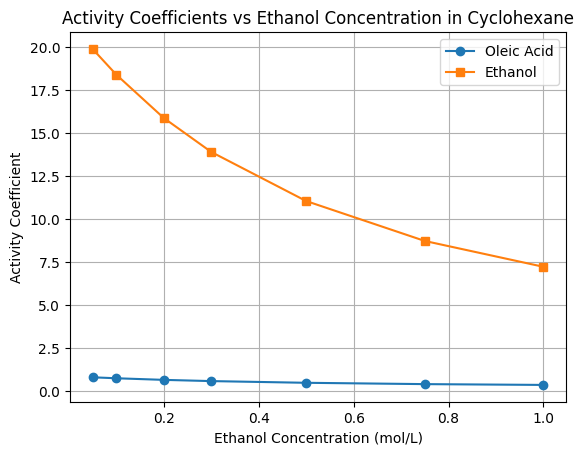

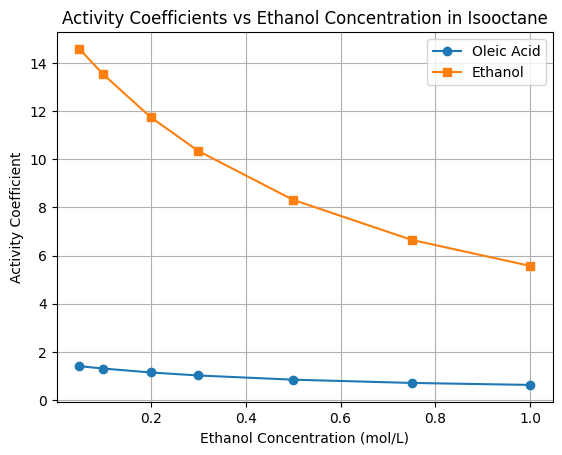

In [ ]:
#with this we have plotted the initial reaction rates for each solvent under the same experimental conditions in a single graph
#to finalize, we will plot the activity coefficients of ethanol and oleic acid for each solvent
ethanol_conc=concentration_datas[1][0]   #X axis
for i, solvent in enumerate(solvent_used):
    activity_coeffs_for_solvent = solvents_activity_coeffs[i]
    oleic_acid_gammas = [coeff[0] for coeff in activity_coeffs_for_solvent]  # index 0: oleic acid
    ethanol_gammas   = [coeff[1] for coeff in activity_coeffs_for_solvent]   # index 1: ethanol
    

    plt.figure()         #we set one figure for each solvent
    #plotting the activity coefficients for different components in the same figure
    plt.plot(ethanol_conc, oleic_acid_gammas, marker='o', label='Oleic Acid')
    plt.plot(ethanol_conc, ethanol_gammas, marker='s', label='Ethanol')
    plt.xlabel("Ethanol Concentration (mol/L)")
    plt.ylabel("Activity Coefficient")
    plt.title(f"Activity Coefficients vs Ethanol Concentration in {solvent.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.show()

## Results comparison
### This last code is designed to compare different systems in a single figure

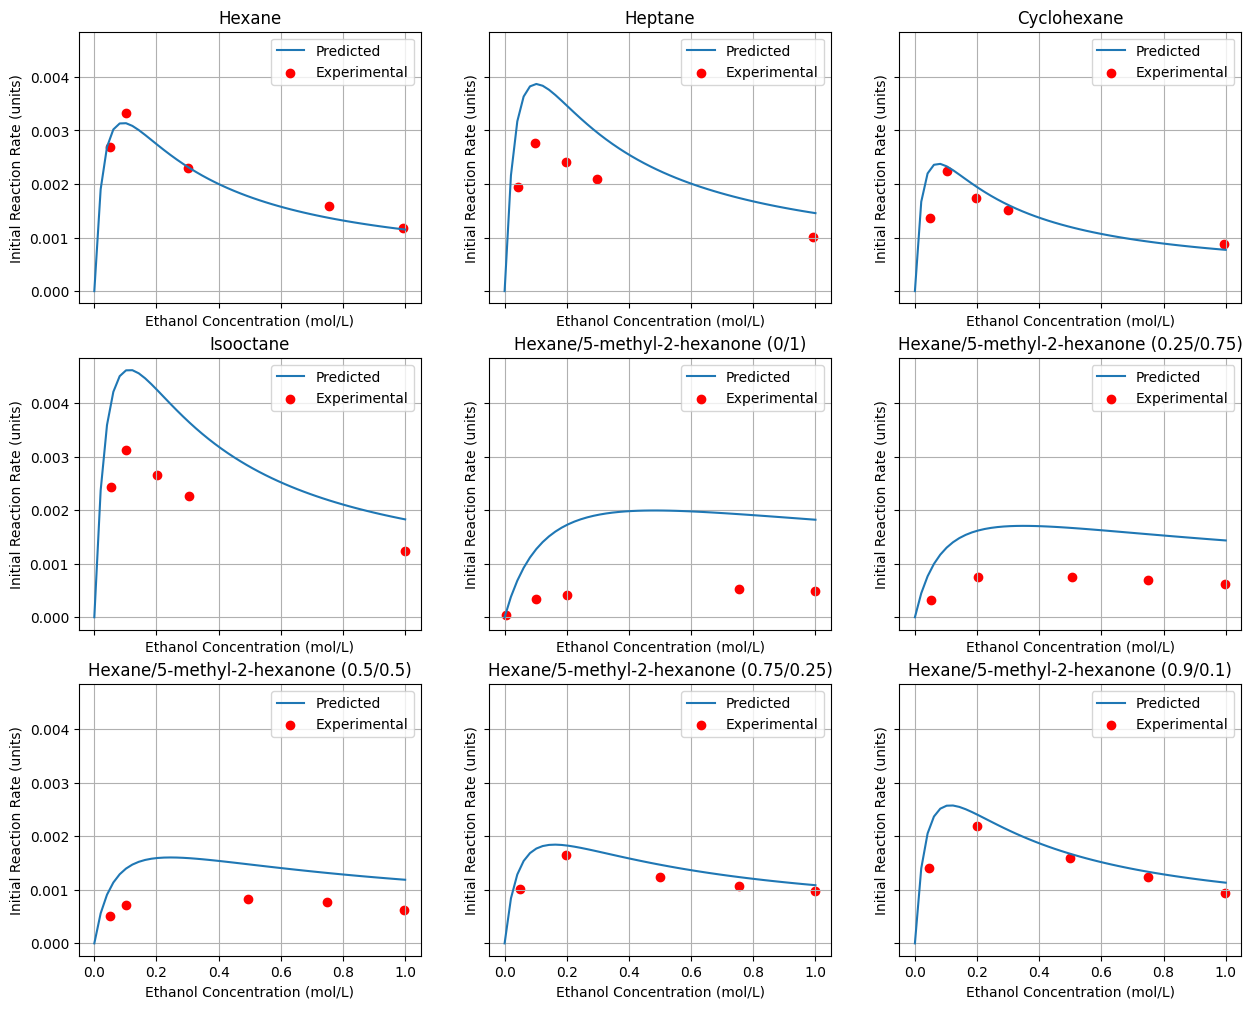

In [ ]:
#to finalize, we will plot the initial reaction rates predictions for each solvent along with the experimental values
#first, we will need to create a list with the experimental results for the different solvents
experimental_conc_points=[[ 0.05075281826219876, 0.10134351835372094, 0.3014810939384415, 0.7549437915790792, 0.9946268886462357],[0.043583535108958856, 0.09685230024213038, 0.19854721549636787, 0.297820823244552, 0.9927360774818403],[0.0480549199084666, 0.10297482837528594, 0.1967963386727688, 0.299771167048055, 0.9931350114416473],[0.052110302880861475, 0.10350370096939405, 0.2031671666735163, 0.3052233592240994, 1],[0.0036968576709796355, 0.10166358595194084, 0.20147874306839188, 0.7541589648798522, 1.0],[0.05175600739371536, 0.20332717190388176, 0.5046210720887244, 0.7504621072088726, 0.9981515711645101],[0.05040650406504065, 0.10081300813008133, 0.4959349593495935, 0.7495934959349593, 0.9967479674796749],[0.05067641004002201, 0.1983422200058818, 0.5013553773958853, 0.7525413326172849, 1.0],[0.04648019641192028, 0.1985038608353095, 0.49983061916552877, 0.7501126295239524, 0.9968952667660833]]
experimental_initial_rx_rates_for_each_solvent=[[0.002688075733451346, 0.0033269997642950258, 0.0022925724071250246, 0.0015921341882489818, 0.001172136785850005],[0.0019479592190416777, 0.0027590823789222467, 0.0024098397183558875, 0.002085077516501038, 0.0010060161321469432],[0.0013685199588190602, 0.0022421133554823247, 0.0017413783026799077, 0.0015237667072781467, 0.0008799532443477735],[0.0024403987269232, 0.003128098741078647, 0.0026576071818335416, 0.00225823631373946, 0.0012319986118531334],[4.089979550102209e-05, 0.0003353783231083841, 0.0004089979550102249, 0.0005316973415132921, 0.0004989775051124741], [0.00032383860881811544, 0.0007487093527437496, 0.0007454181544031266, 0.0006998006146121558, 0.0006128058231248799],[0.0005191956124314442, 0.0007239488117001831, 0.0008263254113345516, 0.0007678244972577699, 0.0006142595978062158],[0.001015267175572519, 0.0016412213740458017, 0.0012366412213740454, 0.0010687022900763363, 0.0009770992366412209],[0.0014012160496198533, 0.002190886961866612, 0.0015999748548039547, 0.0012395743477091672, 0.000942595612861767]]  #this is the experimental initial reaction rates for all solvents
ethanol_conc_range=np.linspace(0,1,50)  #range of ethanol concentrations for plotting
water_conc=[0.6,0.6,0.6,0.6,8.5,6.2,4.5,2.6,0.6]    #water concentration to evaluate for each solvent, where it's value is the mean of each solvent
all_solvents=solvent_used + solvent_mixtures  #this will contain all solvents and solvent mixtures
ncols=3          #number of columns for the subplots
nrows=int(np.ceil(len(all_solvents)/ncols))   #number of rows for the subplot, where we use int to prevent decimal values
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), sharex=True, sharey=True)  #we create the figure and subplots, defining it's dimensions and in this case the x and y axes will be shared across all subplots to compare them
axs = axs.flatten()   #we flatten the axs array to make it easier to iterate trhough
#the following loop´will allow us to plot each solvent in a different subplot
for s in range(len(all_solvents)):
    solvent_to_plot=all_solvents[s]  #the solvent to evaluate
    initial_rx_rates_predictions=[]
    for k in range(len(ethanol_conc_range)):
        #we will calculate the initial rx rate for each ethanol concentration in the range
        evaluated_conc=ethanol_conc_range[k]
        water_evaluated=water_conc[s]
        concentration_datasexp=[[[0.2],'mol/L'],[[evaluated_conc],'mol/L'],[[water_evaluated],'g/L']]  #for each solvent we have a specific water concentration to evaluate
        #now we must determine if this is a mixture or not
        is_mixture=isinstance(solvent_to_plot,list)  #isinstance will return True if the solvent is a mixture(list)
        substrates_MF=get_components_molar_fractions(substrates_and_h2o_present,concentration_datasexp,solvent_to_plot,T,P,is_mixture)  #similarly to previous functions, this will return the molar fractions for each ethanol concentration iteration
        activity_coeffs=get_activity_coefficients(substrates_and_h2o_present,solvent_to_plot,substrates_MF,T,P,is_mixture)
        initial_rx_rate=initial_reaction_rate(substrates_and_h2o_present,concentration_datasexp,substrates_MF,activity_coeffs,optimized_params)
        initial_rx_rates_predictions.append(initial_rx_rate[0][1])   #we append the initial reaction rate predicted for each ethanol concentration iteration
    #now we can plot the initial rx rates
    #prepare label for solvent or mixture
    if isinstance(solvent_to_plot, str):
        title=solvent_to_plot.capitalize()
    else:
        comps="/".join([c.capitalize() for c in solvent_to_plot[0]])
        fractions = "/".join([str(f) for f in solvent_to_plot[1]])
        title=f"{comps} ({fractions})"
    ax=axs[s]      #we determine the current axis to plot
    ax.plot(ethanol_conc_range, initial_rx_rates_predictions, label='Predicted')
    ax.scatter(experimental_conc_points[s],experimental_initial_rx_rates_for_each_solvent[s],color='red',label='Experimental')
    ax.set_xlabel("Ethanol Concentration (mol/L)")
    ax.set_ylabel("Initial Reaction Rate (units)")
    ax.set_title(title)
    ax.legend()   #we add the legend to identify which is the predicted and experimental data
    ax.grid(True)
plt.show()
